# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!pip -q install git+https://github.com/tensorflow/privacy

     |████████████████████████████████| 4.0 MB 14.9 MB/s 


In [4]:
!pip -q install git+https://github.com/qubvel/classification_models.git

     |████████████████████████████████| 50 kB 5.6 MB/s 


##### Import libraries

In [5]:
import os, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from classification_models.tfkeras import Classifiers

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

In [6]:
ResNet50, _ = Classifiers.get('resnet50')

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [7]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
100% 780M/780M [00:03<00:00, 219MB/s]


##### Define constants

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 8
IMG_SHAPE = [224, 224, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.455
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [9]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [10]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [11]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [12]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [13]:
# create train-val-test split with 80-5-15
x_train, x_rest, y_train, y_rest = train_test_split(files, labels, test_size=VAL_SPLIT+TEST_SPLIT, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT), random_state=random_state)

In [14]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7232, Val: 452, Test: 1356


In [15]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [16]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4339, 'COVID-19': 2893}
val set:  {'normal': 272, 'COVID-19': 180}
test set:   {'normal': 813, 'COVID-19': 543}


###### Create tensors

In [17]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [18]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [19]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [20]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [21]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [22]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [23]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [24]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [25]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [26]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=False,
                                    repeat=False,
                                    batch=1,
                                    augment=False,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   augment=False,
                                   cache=False)

### Visualization

###### Distribution of labels in the sets

In [27]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

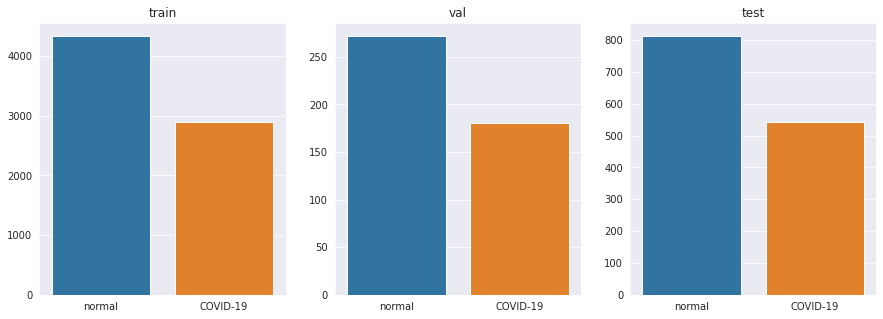

In [28]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [29]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [30]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


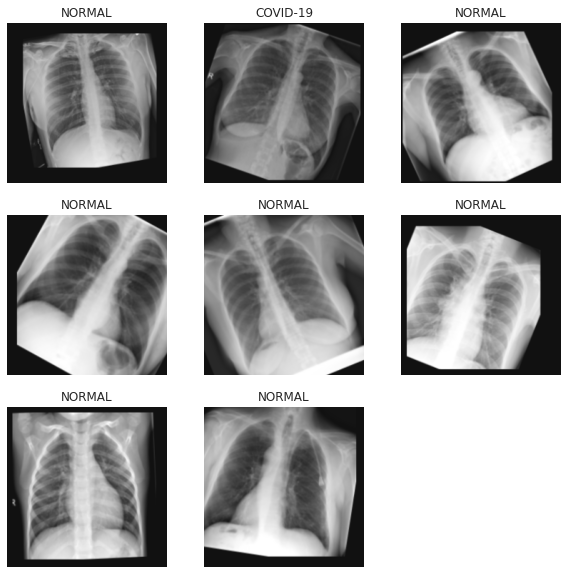

In [31]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [32]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [33]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## ResNet18
[Paper](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)

### Model definition

In [34]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride, name=name + 'pool_pool')(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    # bottom
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    # body
    x = stack_fn(x)
    # no top added
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet50_tanh(input):
    def stack_fn(x):
        x = resnet_stack(x, 64, 3, name='conv2')
        x = resnet_stack(x, 128, 4, name='conv3')
        x = resnet_stack(x, 256, 6, name='conv4')
        x = resnet_stack(x, 512, 3, stride1=1, name='conv5')
        x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
        x = Activation('tanh', name='post_tanh')(x)
        return x
    return ResNet(stack_fn, input, 'resnet50v2')

In [35]:
def resnet50_builder(weights=False, dropout=False, activation='relu', name='ResNet50'):
    # ResNet50 without head
    if activation == 'tanh':
        resnet50 = ResNet50_tanh(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    elif activation == 'relu':
        _weights = False if weights == 'pneumonia' else weights
        resnet50 = ResNet50(include_top = False,
                            weights = _weights,
                            input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    
    resnet50.trainable = True # make layers trainable

    seq = [
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]), name='Input'),
        resnet50, # add resnet50 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ]

    if dropout:
        seq.insert(3, Dropout(rate=dropout, name='Dropout')) # add dropout (inspired by inception-resnet-v2))

    model = Sequential(seq, name=name)

    # load weights from pneumonia pretraining
    if weights == 'pneumonia' and activation == 'relu':
        model.load_weights(weights_path+'resnet50_relu_public_weights.h5', by_name=True)
    if weights == 'pneumonia' and activation == 'tanh':
        model.load_weights(weights_path+'resnet50_tanh_public_weights.h5', by_name=True)
    
    return model

In [36]:
#resnet50 = resnet50_builder(name='ResNet50')
#resnet50_dropout = resnet50_builder(dropout=0.2, name='ResNet50-dropout')
#resnet50_imagenet = resnet50_builder(weights='imagenet', name='ResNet50-imagenet')

#resnet50_tanh = resnet50_builder(activation='tanh', name='ResNet50-tanh')
#resnet50_tanh_dropout = resnet50_builder(activation='tanh', dropout=0.2, name='ResNet50-tanh-dropout')
resnet50_tanh_pneumonia = resnet50_builder(activation='tanh', weights='pneumonia', name='ResNet50-tanh-pneumonia')

models = [
    #resnet50,
    #resnet50_dropout,
    #resnet50_imagenet,
    #resnet50_tanh,
    #resnet50_tanh_dropout,
    resnet50_tanh_pneumonia,
]

METRICS = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

for model in models:
    if model.name == 'ResNet50-imagenet-lr':
        model.compile(
            optimizer=VectorizedDPKerasAdamOptimizer(
                l2_norm_clip=L2_NORM_CLIP,
                noise_multiplier=NOISE_MULTIPLIER,
                num_microbatches=MICROBATCHES,
                learning_rate=1e-5
            ),
            loss=BinaryCrossentropy(
                from_logits=True,
                reduction=tf.compat.v1.losses.Reduction.NONE
                # reduction is set to NONE to get loss in a vector form
            ),
            metrics=METRICS
        )
    else:
        model.compile(
            optimizer=VectorizedDPKerasAdamOptimizer(
                l2_norm_clip=L2_NORM_CLIP,
                noise_multiplier=NOISE_MULTIPLIER,
                num_microbatches=MICROBATCHES,
                learning_rate=1e-3
            ),
            loss=BinaryCrossentropy(
                from_logits=True,
                reduction=tf.compat.v1.losses.Reduction.NONE
                # reduction is set to NONE to get loss in a vector form
            ),
            metrics=METRICS
        )

In [37]:
models[0].summary()

Model: "ResNet50-tanh-pneumonia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 AvgPool (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Output (Dense)              (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [38]:
for model in models:
    print("Training %s ..." % (model.name))
    history = model.fit(
        train_batched,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_batched,
        validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
        class_weight=class_weight_dict,
        callbacks = [learning_rate_decay],
    )
    print('\n')

Training ResNet50-tanh-pneumonia ...
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


904/904 [==============================] - 482s 469ms/step - loss: 1.0573 - accuracy: 0.7027 - precision: 0.5993 - recall: 0.7753 - val_loss: 5.6954 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
904/904 [==============================] - 422s 467ms/step - loss: 1.1636 - accuracy: 0.7205 - precision: 0.6180 - recall: 0.7895 - val_loss: 3.8522 - val_accuracy: 0.6004 - val_precision: 0.4848 - val_recall: 0.0899 - lr: 0.0010
Epoch 3/20
904/904 [==============================] - 422s 467ms/step - loss: 1.2201 - accuracy: 0.7192 - precision: 0.6174 - recall: 0.7833 - val_loss: 8.3819 - val_accuracy: 0.3973 - val_precision: 0.3964 - val_recall: 0.9888 - lr: 0.0010
Epoch 4/20
904/904 [==============================] - 422s 467ms/step - loss: 1.2959 - accuracy: 0.7212 - precision: 0.6194 - recall: 0.7864 - val_loss: 2.1791 - val_accuracy: 0.6853 - val_precision: 0.5693 - val_recall: 0.8539 - lr: 0.0010
Epoch 5/20
904/904 [===================

## Evaluation

In [39]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating ResNet50-tanh-pneumonia ...
170/170 [==============================] - 5s 28ms/step - loss: 2.0454 - accuracy: 0.7161 - precision: 0.5892 - recall: 0.9613




### Privacy Analysis

#### Compute epsilon

In [40]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [41]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [42]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 10.014


In [43]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 10.0
noise = compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)
print(noise)

DP-SGD with sampling rate = 0.111% and noise_multiplier = 0.4551486611378193 iterated over 18080 steps satisfies differential privacy with eps = 10 and delta = 0.0001.
0.4551486611378193


#### Membership Inference Attack

In [44]:
def compute_attack_inputs(model, attack_data):
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant
    # get labels
    labels = []
    for x, y in attack_data.as_numpy_iterator():
        labels.append(y[0])
    # predict
    probs = model.predict(attack_data)
    # compute loss
    losses = np.array([x[0] for x in bc(constant([[y] for y in labels]), constant(probs), from_logits=False).numpy()])
    
    return (np.array(probs), np.array(losses), np.array(labels))

# run membership inference attack
def run_mia(model, train_attack_input, test_attack_input):
    # prepare attacks
    probs_train, loss_train, labels_train = train_attack_input
    probs_test, loss_test, labels_test = test_attack_input

    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    #plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    #plt.show()

    # print a user-friendly summary of the attacks
    #print(attacks_result.summary(by_slices=False))

    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    max_adv = attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

    return max_auc, max_adv

# epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
def empirical_eps(auc):
    if auc <= 0.5:
        return 0
    if auc == 1:
        return np.inf
    return np.log(auc / (1 - auc))

from contextlib import contextmanager
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [45]:
import scipy.stats as st

for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    SAMPLE_NB = 100
    
    train_attack_input = compute_attack_inputs(model, train_attack_data)
    test_attack_input = compute_attack_inputs(model, test_attack_data)

    aucs = []
    advs = []
    emp_eps = []
    for i in range(SAMPLE_NB):
        with suppress_stdout():
            max_auc, max_adv = run_mia(model, train_attack_input, test_attack_input)
        aucs.append(max_auc)
        advs.append(max_adv)
        emp_eps.append(empirical_eps(max_auc))

    auc_low, auc_high = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
    adv_low, adv_high = st.t.interval(0.95, len(advs)-1, loc=np.mean(advs), scale=st.sem(advs))
    eps_low, eps_high = st.t.interval(0.95, len(emp_eps)-1, loc=np.mean(emp_eps), scale=st.sem(emp_eps))

    print('95%%-CI based on %i attack samples'%(SAMPLE_NB))
    print('AUC: %0.2f-%0.2f'%(auc_low, auc_high))
    print('Attacker advantage: %0.2f-%0.2f'%(adv_low, adv_high))
    print('Empirical epsilon bounds from AUC: %0.2f-%0.2f\n'%(eps_low, eps_high))

Membership Inference Attack on ResNet50-tanh-pneumonia...
95%-CI based on 100 attack samples
AUC: 0.54-0.55
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.16-0.19

